In [3]:
import pynbody
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.modeling import models, fitting
from photutils import isophote, aperture_photometry
from photutils import CircularAperture, EllipticalAperture, EllipticalAnnulus
from photutils.isophote import EllipseGeometry, Ellipse
import ipywidgets
from simulation.luminosity import surface_brightness, color_plot, kpc2pix

In [4]:
def bounding_box(snap):
    unit = snap['pos'].units
    for coord in 'x y z'.split():
        print("{}: {:10.2f}, {:10.2f} ({})".format(coord, snap[coord].min(), snap[coord].max(), unit))
    return [(float(snap[coord].min()), float(snap[coord].max())) for coord in 'x y z'.split()]

In [5]:
def to_astropy_quantity(simarr, units=None):
    return u.Quantity(simarr.view(type=np.ndarray), unit=units if units is not None else str(simarr.units))

In [6]:
def ss_angmom(flux, r, v_los, v_disp):
    return np.sum(flux * r * np.abs(v_los)) / np.sum(flux * r * np.sqrt(v_los**2 + v_disp**2))
def compute_stellar_specific_angmom(snap, width, resolution, radii, eccentricity, a_delta, theta):
    luminosity_sim = surface_brightness(snap.s, band='v', width=width, resolution=resolution, mag_filter=None, cmap_name='Greys')
    v_los_sim = pynbody.plot.sph.image(snap.s, qty='vz', av_z='rho', width=width, resolution=resolution, log=False)
    v_disp_sim = pynbody.plot.sph.image(snap.s, qty='v_disp', av_z='rho', width=width, resolution=resolution, log=False)
    lum = to_astropy_quantity(luminosity_sim, units='mag/arcsec**2')
    v_los = to_astropy_quantity(v_los_sim)
    v_disp = to_astropy_quantity(v_disp_sim)
    lum_annuli = integrate_annulus(lum, center, radii, eccentricity, a_delta, theta)
    v_los_annuli = integrate_annulus(v_los, center, radii, eccentricity, a_delta, theta)
    v_disp_annuli = integrate_annulus(v_disp, center, radii, eccentricity, a_delta, theta)
    stellar_specific_angmom = ss_angmom(lum_annuli, radii, v_los_annuli, v_disp_annuli)
    return stellar_specific_angmom

In [7]:
def fit_sersic(img, r_eff, n, ellip, theta):
    res_x, res_y = img.shape
    y, x = np.mgrid[:res_x, :res_y]
    s_init = models.Sersic2D(r_eff=r_eff, n=n, x_0=res_x/2, y_0=res_y/2, ellip=ellip, theta=theta,
                         fixed={'amplitude':False, 'n':False, 'ellip':False, 'x_0':True, 'y_0':True},
                         bounds={})#'theta':(0, np.pi)})
    fit_s = fitting.SLSQPLSQFitter()
    # notnans = np.isfinite(img)
    # sersic = fit_s(s_init, x[notnans], y[notnans], img[notnans])
    sersic = fit_s(s_init, x, y, img)
    return sersic

In [8]:
def plot_fit(img, fit):
    # Plot the data with the best-fit model
    res_x, res_y = img.shape
    y, x = np.mgrid[:res_x, :res_y]
    plt.figure(figsize=(12,2.5))
    plt.subplot(1,3,1)
    data = plt.imshow(img, origin='lower', interpolation='nearest')
    plt.title("Data")
    plt.colorbar(data)
    plt.subplot(1,3,2)
    mod = plt.imshow(fit(x, y), origin='lower', interpolation='nearest')
    plt.colorbar(mod)
    plt.title("Model")
    plt.subplot(1,3,3)
    residual = img - fit(x, y)
    res = plt.imshow(residual, origin='lower', interpolation='nearest')
    plt.colorbar(res)
    plt.title("Residual");
    print("residual: ({:.4f}, {:.4f})".format(residual.min(), residual.max()))

In [9]:
def plot_angmom(snap, ax):
    """Plot the projected angular momentum on the map on `ax`, after having
    normalized it to one. It means that short arrows plotted means L almost
    aligned with line-of-sight-direction."""
    L = pynbody.analysis.angmom.ang_mom_vec(snap)
    print("L:", L)
    norm = np.linalg.norm(L)
    ax.arrow(0, 0, L[0]/norm, L[1]/norm, head_width=0.2, head_length=.2, color='red');

In [42]:
def compute_rms_error(x, y):
    return np.sqrt(np.sum((x-y)**2)/len(x))

In [12]:
snap = "/mnt/data/MoRIA/M1-10_Verbeke2017/M10sim41001/snapshot_0036"
s = pynbody.load(snap)

In [13]:
max_boxsize = 4000

In [14]:
s.properties['boxsize'] = pynbody.units.Unit("{} kpc".format(max_boxsize))

In [15]:
s.properties

{'time': Unit("1.34e+01 s kpc km**-1"), 'boxsize': Unit("4.00e+03 kpc")}

In [16]:
width = 5
resolution = 500

In [17]:
pynbody.analysis.halo.center(s.g)#, vel=False)
subsnap = s[pynbody.filt.Cuboid('{} kpc'.format(-width*1.1))]

L: [ 0.05722479  0.55011135 -0.09821207]


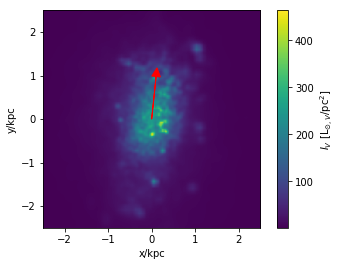

In [18]:
pynbody.analysis.angmom.sideon(subsnap.s)
# subsnap.rotate_y(90)
fig, ax = plt.subplots()
sb = surface_brightness(subsnap.s, width=width, resolution=resolution, subplot=ax, lum_pc2=True)
L = pynbody.analysis.angmom.ang_mom_vec(subsnap.s)
plot_angmom(subsnap.s, ax)

L: [ 0.05751329  0.5515289  -0.09816755]
L: [-4.6473026  2.4215581 -2.1254942]


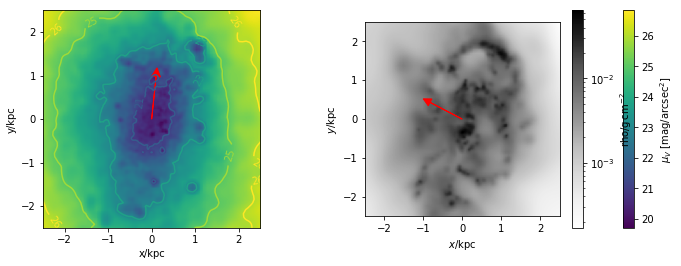

In [19]:
pynbody.analysis.angmom.sideon(subsnap.s)
fig, (ax, ax_g) = plt.subplots(ncols=2, figsize=(12, 4))
sb = surface_brightness(subsnap.s, width=width, resolution=resolution, subplot=ax, isophotes=5)
L = pynbody.analysis.angmom.ang_mom_vec(subsnap.s)
plot_angmom(subsnap.s, ax)

pynbody.plot.sph.image(subsnap.g, qty="rho", units="g cm^-2", width=width, cmap="Greys", subplot=ax_g);
L = pynbody.analysis.angmom.ang_mom_vec(subsnap.g)
plot_angmom(subsnap.g, ax_g)

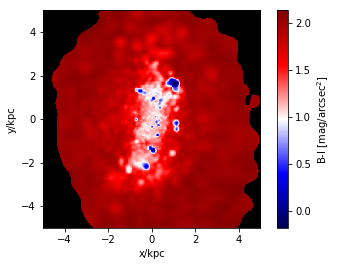

In [20]:
fig, ax = plt.subplots()
sb = color_plot(subsnap.s, width=10, resolution=resolution, subplot=ax, mag_filter=29)
# L = pynbody.analysis.angmom.ang_mom_vec(subsnap.s)
# plot_angmom(subsnap.s, ax)

In [21]:
def minmax_normalization(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

In [22]:
def one_sigma_normalization(arr):
    return (arr - arr.mean()) / arr.std()

2.7124697e-05 0.002799936


(0.0, 1.0)

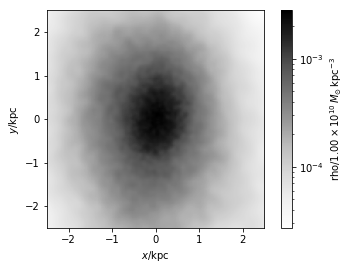

In [23]:
weights = pynbody.plot.sph.image(subsnap.s, qty="rho", av_z=True, width=width, cmap="Greys", log=True);
weights_norm = minmax_normalization((weights).view(np.ndarray))
print(weights.min(), weights.max())
weights_norm.min(), weights_norm.max()

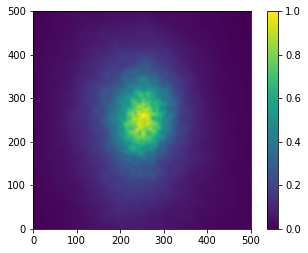

In [24]:
plt.imshow(weights_norm, origin='lower')
plt.colorbar()

In [25]:
np.linspace(sb.min(), sb.max(), 5, dtype=np.int)

/home/michele/Software/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/home/michele/Software/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


SimArray([-9223372036854775808, -9223372036854775808,
          -9223372036854775808, -9223372036854775808,
          -9223372036854775808], 'arcsec**-2')

In [26]:
r_eff_kpc3d = pynbody.analysis.luminosity.half_light_r(subsnap, cylindrical=False)
r_eff_kpc3d

SimArray(1.1890358, 'kpc')

In [27]:
r_eff_kpc = pynbody.analysis.luminosity.half_light_r(subsnap, cylindrical=True)
r_eff_kpc

SimArray(0.91331476, 'kpc')

In [28]:
r_eff = kpc2pix(r_eff_kpc, width, resolution)
r_eff

91

## undoing conversion from pynbody.analisys.profile.sb.
At 10 pc (distance for absolute magnitudes), 1 arcsec is 10 AU=1/2.06e4 pc. In fact:

In [30]:
arcsec = arcsec2_over_pc2_at_10pc = (np.tan(np.pi/180/3600)*10.0)**2
# 1 square arcsecond is thus 2.35e-9 pc^2
arcsec2_over_pc2_at_10pc

2.350443053946619e-09

In [31]:
-2.5*np.log10(arcsec2_over_pc2_at_10pc)

21.572125665865283

Text(0.5, 0, 'r/kpc')

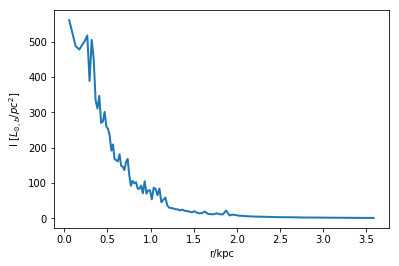

In [32]:
binning='equaln' # contain equal numbers of particles
band='b'
sun_abs_mag = {'u':5.56,'b':5.45,'v':4.8,'r':4.46,'i':4.1,'j':3.66,
               'h':3.32,'k':3.28}[band]
ps = pynbody.analysis.profile.Profile(subsnap.s, type=binning, max=4*r_eff_kpc, bin=100)
r = ps['rbins'].in_units('kpc')
# sbp = 10**(0.4*(sun_abs_mag - 2.5*np.log10(arcsec2_over_pc2_at_10pc) - ps['sb,' + band] ))
sbp = 10**(0.4*(sun_abs_mag + 21.572 - ps['sb,' + band] ))
plt.plot(r, sbp, linewidth=2);
plt.ylabel("I [$L_{{\odot,{}}}/pc^2$]".format(band))
plt.xlabel("r/kpc")

In [33]:
r_eff_kpc3d

SimArray(1.1890358, 'kpc')

# Fit 1D sersic 

In [34]:
s1D_init = models.Sersic1D(r_eff=r_eff_kpc3d, n=2, fixed={'amplitude':False, 'r_eff':False, 'n':False})
# s1d_init = models.ExponentialCutoffPowerLaw1D(alpha=1, x_cutoff=3)
fit_s1D = fitting.SLSQPLSQFitter()
sersic1D = fit_s1D(s1D_init, r, sbp)#, acc=1e-10)
sersic1D

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 56165.015210132115
            Iterations: 47
            Function evaluations: 271
            Gradient evaluations: 47


/home/michele/Software/miniconda3/lib/python3.6/site-packages/pynbody/array.py:463: RuntimeWarning: invalid value encountered in power
  r = np.asarray(np.power(self.view(np.ndarray), numerical_x)).view(SimArray)


<Sersic1D(amplitude=208.53501843, r_eff=0.58706542, n=0.69696441)>

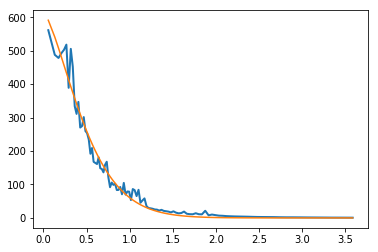

In [35]:
plt.plot(r, sbp, linewidth=2)
plt.plot(r, sersic1D(r))
# plt.plot(r, max(sersic1d(r)) - sersic1d(r))
# plt.ylim(max(sbp), min(sbp))

In [36]:
sersic1D(sersic1D.r_eff), sersic1D.amplitude.value

(208.53501842511736, 208.53501842511736)

# Fit 2D sersic

Redo the plot

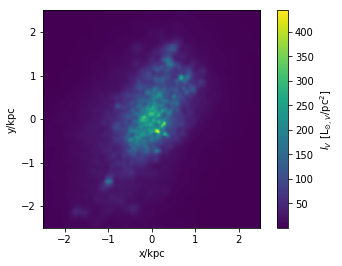

In [37]:
pynbody.analysis.angmom.sideon(subsnap.s)
# subsnap.rotate_y(90)
fig, ax = plt.subplots()
sb = surface_brightness(subsnap.s, width=width, resolution=resolution, subplot=ax, lum_pc2=True, isophotes=5, center=True)

In [38]:
r_eff = kpc2pix(sersic1D.r_eff, width, resolution)
r_eff

58

In [66]:
ellipticity = 0.5
theta = 0*np.pi/180
n = sersic1D.n
r_eff

58

In [67]:
def evaluate_fitter(fit_s, r_eff=r_eff, n=n, x_0=resolution/2, y_0=resolution/2, ellip=ellipticity, theta=theta, **kwargs):
    y, x = np.mgrid[:resolution, :resolution]
    s_init = models.Sersic2D(r_eff=r_eff, n=n, x_0=resolution/2, y_0=resolution/2, ellip=ellipticity, theta=theta,
                             fixed={'amplitude':False, 'r_eff':True, 'n':False, 'x_0':True, 'y_0':True, 'ellip':False, 'theta':False})#,
    #                          bounds={ 'ellip':(0,1)}) #, 'x_0':(200,300) 'y_0':(200,300),
    sersic = fit_s(s_init, x, y, sb, **kwargs)#, weights=weights_norm, maxiter=200)
    print(sersic)
    plot_fit(sb, sersic)
    print("RMS: ", compute_rms_error(sb, sersic(x, y)))

Model: Sersic2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
        amplitude     r_eff ...        ellip               theta        
    ----------------- ----- ... ------------------- --------------------
    83.02670200103265  58.0 ... -0.9835206996997037 -0.48402941029251834
residual: (-70.5002, 262.5600)
RMS:  298.1028098829013


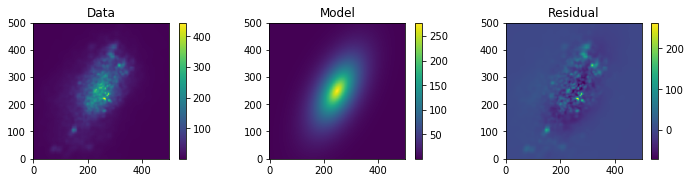

In [68]:
evaluate_fitter(fitting.SimplexLSQFitter(), maxiter=1000)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 44432642.63004095
            Iterations: 29
            Function evaluations: 212
            Gradient evaluations: 29
Model: Sersic2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
        amplitude     r_eff ...       ellip               theta       
    ----------------- ----- ... ------------------ -------------------
    83.02669816997766  58.0 ... 2.9835207519519096 -0.4840294099974015
residual: (-70.5002, 262.5600)
RMS:  298.1028098829025


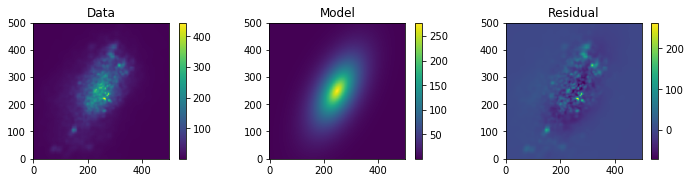

In [69]:
evaluate_fitter(fitting.SLSQPLSQFitter())

In [51]:
y, x = np.mgrid[:resolution, :resolution]
s_init = models.Sersic2D(r_eff=r_eff, n=n, x_0=resolution/2, y_0=resolution/2, ellip=ellipticity, theta=theta,
                         fixed={'amplitude':False, 'r_eff':True, 'n':False, 'x_0':True, 'y_0':True, 'ellip':False, 'theta':False})#,
#                          bounds={ 'ellip':(0,1)}) #, 'x_0':(200,300) 'y_0':(200,300),
# s_init = models.Polynomial2D(degree=4)
# s_init = models.Gaussian2D(x_mean=resolution/2, y_mean=resolution/2, theta=theta,
#                            fixed={'amplitude':False, 'x_mean':False, 'y_mean':False, 'theta':False}, 
#                            bounds={'theta':(0, np.pi), 'x_mean':(200,300), 'y_mean':(200,300)})

fit_s = fitting.SLSQPLSQFitter()
# fit_s = fitting.SimplexLSQFitter()

# notnans = np.isfinite(img)
# sersic = fit_s(s_init, x[notnans], y[notnans], img[notnans])
sersic = fit_s(s_init, x, y, sb)#, weights=weights_norm, maxiter=200)
sersic

<Sersic2D(amplitude=83.02670187, r_eff=58., n=0.76102304, x_0=250., y_0=250., ellip=-0.9835207, theta=-0.48402941)>

residual: (-70.5002, 262.5600)


<Sersic2D(amplitude=83.02670187, r_eff=58., n=0.76102304, x_0=250., y_0=250., ellip=-0.9835207, theta=-0.48402941)>

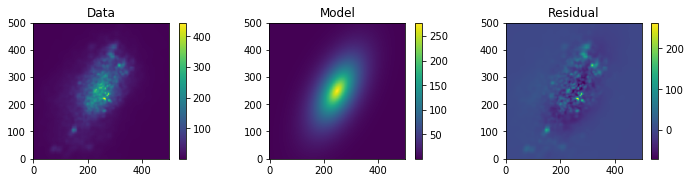

In [53]:
plot_fit(sb, sersic)
sersic

In [54]:
sersic.theta, sersic.ellip

(Parameter('theta', value=-0.4840294106466136),
 Parameter('ellip', value=-0.9835207032742002))

## Error

In [55]:
compute_rms_error(sb, sersic(x, y))

SimArray(298.10280988, 'pc**-2')